In [5]:
import pandas as pd
import numpy as np
import networkx as nx
import operator as op
import itertools
import matplotlib.pyplot as plt
import numpy.linalg
import cmath
import multiprocessing
import itertools
import scipy.optimize as optimize

%matplotlib inline

In [6]:
#Load the dataset
data=pd.read_csv("sx-stackoverflow.txt", sep=" ", header=None)
#Rename the columns
data.columns= ["source_id", "target_id", "timestamp"]

For testing purpose,we decided to create a smaller dataset with only 1000 records

In [7]:
#Create a small dataset for testing
dataset=data.iloc[0:1000]

Also we created a smaller dummy dataset in order to evaluate the results by hand the results

In [8]:
#Dummy Data set
dummy=pd.DataFrame([[9, 2, 1],[8, 2, 2],[5, 2, 5],[8, 2, 7],[5, 2, 10]
                      ,[5, 2, 12],[7, 2, 16],[11, 2, 20],[5, 2, 21]],columns = ["source_id", "target_id", "timestamp"])    

dummy.source_id = dummy.source_id.astype(int)
dummy.target_id = dummy.target_id.astype(int)
t_min=dummy.timestamp.min()
t_max=dummy.timestamp.max()
N=10


## Part I

The following function takes two arguments, the dataset and a number. It splits the dataset in N time intervals.

In [9]:
def create_intervals(dataset,N):


    t_min=dataset.timestamp.min()
    t_max=dataset.timestamp.max()


    dt=(t_max-t_min)/N
    
    intervals=[]
    for j in range(0,N):

        #Start of time interval
        tj=t_min + j*dt
        
        #End of time interval
        tj1=t_min +(j+1)*dt

        intervals.append([int(tj),int(tj1)])

    return(intervals)

We decided to create a custom python class for graph objects with four properties. The properties are:

* t0 : The stasting time
* t1 : The ending time
* dataset : The dataset
* interval : The time range [t0,t1]

In [10]:
class graph(object):
    def __init__(self,dataset, t0,t1):
        self.t0 = t0
        self.t1 = t1
        self.dataset = dataset
        self.create_graph()
        self.interval=[t0,t1]
        
    def create_graph(self):
        self.batch = self.create_batch()
        self.graph = nx.from_pandas_edgelist(self.batch, 'source_id', 'target_id')
        

    def create_batch(self):
        
        df_indexes=[]
        index = 0
        self.dataset = self.dataset.reset_index(drop=True)
            
        if self.t1 == self.dataset.timestamp.max():
            while index < len(self.dataset)and self.dataset.timestamp[index]<=self.t1 :
                if self.dataset.timestamp[index]>=self.t0:
                    df_indexes.append(index)
                    
                index = index +1

            batch = self.dataset.iloc[df_indexes]

            return(batch)

        else:
            while index < len(self.dataset)and self.dataset.timestamp[index]<self.t1 :
                if self.dataset.timestamp[index]>=self.t0:
                    df_indexes.append(index)
                    
                index = index +1

            batch = self.dataset.iloc[df_indexes]
            
            return(batch)
        


For the following questions we created functions which compute the volume(count) of the edges and vertices.

In [11]:
def graph_vertices_volume(dataset,N):
    
    time_intervals = create_intervals(dataset,N)
    nodes_count_list=[]

    for time_interval in time_intervals:
        G=graph(dataset, time_interval[0], time_interval[1])
        nodes_count_list.append(len(G.graph.nodes()))
        
    return(nodes_count_list)
       

def vertices_graph(dataset,N):
    T=[]

    time_intervals = create_intervals(dataset,N)
    for time_interval in time_intervals:
        T.append(time_interval[0])

    x = T  
    y = graph_vertices_volume(dataset,N)

    N = len(y)
    x = range(N)
    width = 1/1.5
    
    plt.subplot(1, 2, 1)
    plt.title('Vertices Histogram')
    plt.xlabel('Time Intervals Bins')
    plt.ylabel('Number of Vertices')
    plt.bar(x, y, align='edge',color="blue")

In [12]:
def graph_edges_volume(dataset,N):
    
    time_intervals = create_intervals(dataset,N)
    edges_count_list=[]

    for time_interval in time_intervals:
        G=graph(dataset, time_interval[0], time_interval[1])
        edges_count_list.append(len(G.graph.edges()))
        
    return(edges_count_list)
       

def edges_graph(dataset,N):
    T=[]

    time_intervals = create_intervals(dataset,N)
    for time_interval in time_intervals:
        T.append(time_interval[0])

    x = T  
    y = graph_edges_volume(dataset,N)

    N = len(y)
    x = range(N)
    width = 1/1.5
    
    plt.subplot(1, 2, 2)
    plt.title('Edges Histogram')
    plt.xlabel('Time Intervals Bins')
    plt.ylabel('Number of Edges')
    plt.bar(x, y, align='edge',color="magenta")

The original dataset is very large and the computations take a lot of time. So, we create a plitting function that help us to
manipulate this large dataset.Finally, we create n-smaller dataset and then we split each one in N-number of intervals.

In [13]:
def graph_creator(dataset, n, N):
    data_rows = len(dataset)
    step = round(data_rows/n)
    start=0
    stop=step
    for pointer in range(0,data_rows,step):
        
        vertices_graph(dataset.iloc[start:stop],N)
        edges_graph(dataset.iloc[start:stop],N)
        
        plt.tight_layout()
        plt.show()
        plt.clf()
        
        start = start + step
        stop = start + step


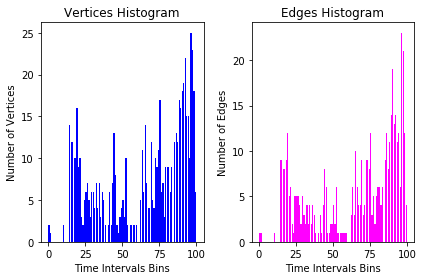

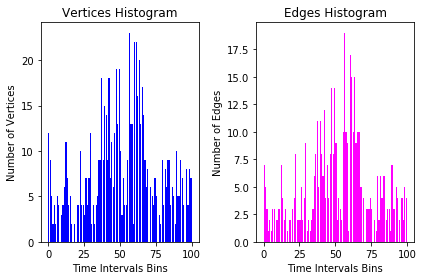

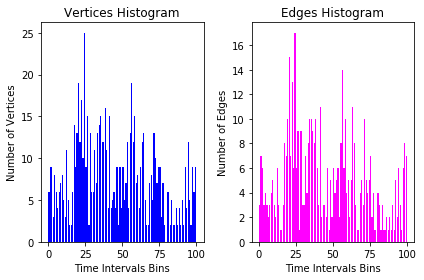

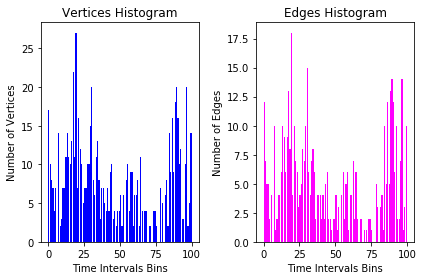

<Figure size 432x288 with 0 Axes>

In [94]:
#e.x we take the batch1_dataset and we split it in 4 smaller datasets and 100 intervals each one
graph_creator(dataset,4,100) 

In [10]:
def compute_n_plot_centralities(G):
    
    f = plt.figure(figsize=(15,15))
    ax1 = f.add_subplot(231)
    ax2 = f.add_subplot(232)
    ax3 = f.add_subplot(233)
    ax4 = f.add_subplot(234)
    ax5 = f.add_subplot(235)
    
    #Degree Centrality
    dc = nx.degree_centrality(G.graph)
    dc_values = np.asarray(list(dc.values()))
    ax1.hist(dc_values, weights = np.zeros_like(dc_values) + 1. / dc_values.size)
    ax1.set_ylabel('Relative Frequency')
    ax1.set_title('Degree Centrality')

    #Closeness Centrality
    cc = nx.closeness_centrality(G.graph)
    cc_values = np.asarray(list(cc.values()))
    ax2.hist(cc_values, weights = np.zeros_like(cc_values) + 1. / cc_values.size)
    ax2.set_title('Closeness Centrality')

    #Betweenness Centrality
    bc = nx.betweenness_centrality(G.graph)
    bc_values = np.asarray(list(bc.values()))
    ax3.hist(bc_values, weights = np.zeros_like(bc_values) + 1. / bc_values.size)
    ax3.set_title('Betweeness Centrality')

    #Eigenvector Centrality
    ec = nx.eigenvector_centrality_numpy(G.graph)
    ec_values = np.asarray(list(ec.values()))
    ax4.hist(ec_values, weights = np.zeros_like(ec_values) + 1. / ec_values.size)
    ax4.set_ylabel('Relative Frequency')
    ax4.set_xlabel('Normalized Centrality Measure Values')
    ax4.set_title('Eigenvector Centrality') 
    
    #Katz Centrality
    L = nx.normalized_laplacian_matrix(G.graph)
    e = numpy.linalg.eigvals(L.A)
    kc = nx.katz_centrality_numpy(G.graph, max(e).real)
    kc_values = np.asarray(list(kc.values()))
    ax5.hist(kc_values, weights = np.zeros_like(kc_values) + 1. / kc_values.size)
    ax5.set_xlabel('Normalized Centrality Measure Values')
    ax5.set_title('Katz Centrality')
      
    plt.show()

The following function runs the compute_n_plot_centralities function for all subgraphs (n-smaller datasets and  N-time intervals)

In [11]:
def graph_centralities_creator(dataset, n, N):
    data_rows = len(dataset)
    step = round(data_rows/n)
    start=0
    stop=step
    
    for pointer in range(0,data_rows,step):
        
        intervals = create_intervals(dataset.iloc[start:stop],N)
        
        for interval in intervals:
            G=graph(dataset.iloc[start:stop],interval[0],interval[1])
            compute_n_plot_centralities(G)
        
        start = start + step
        stop = start + step

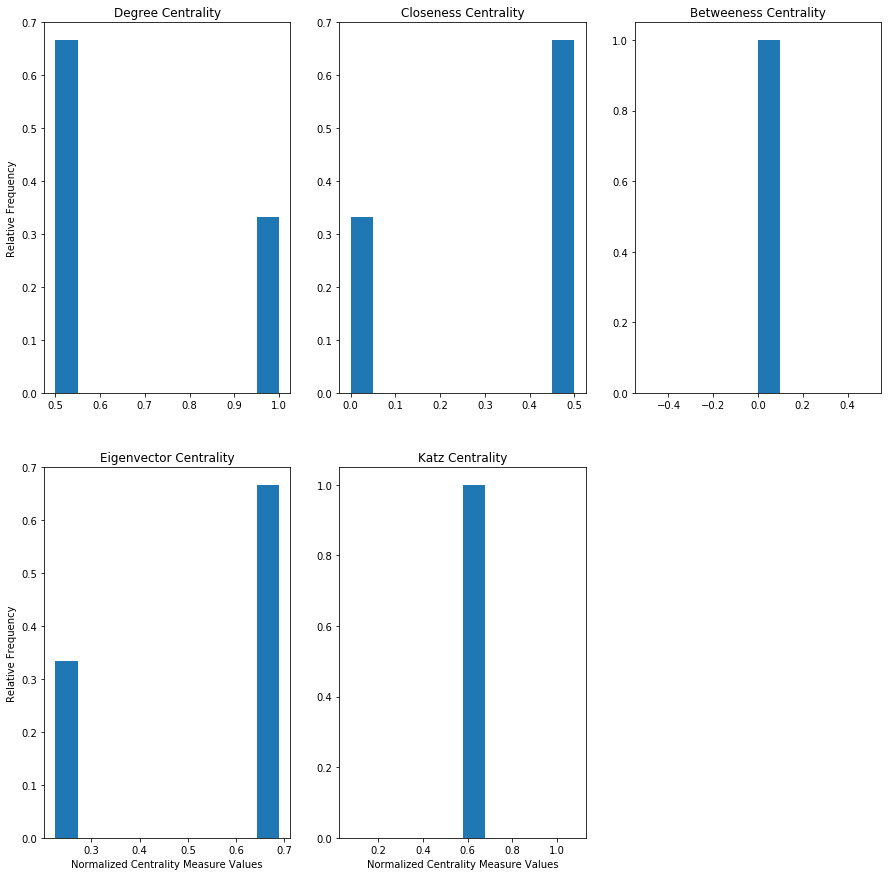

ZeroDivisionError: float division by zero

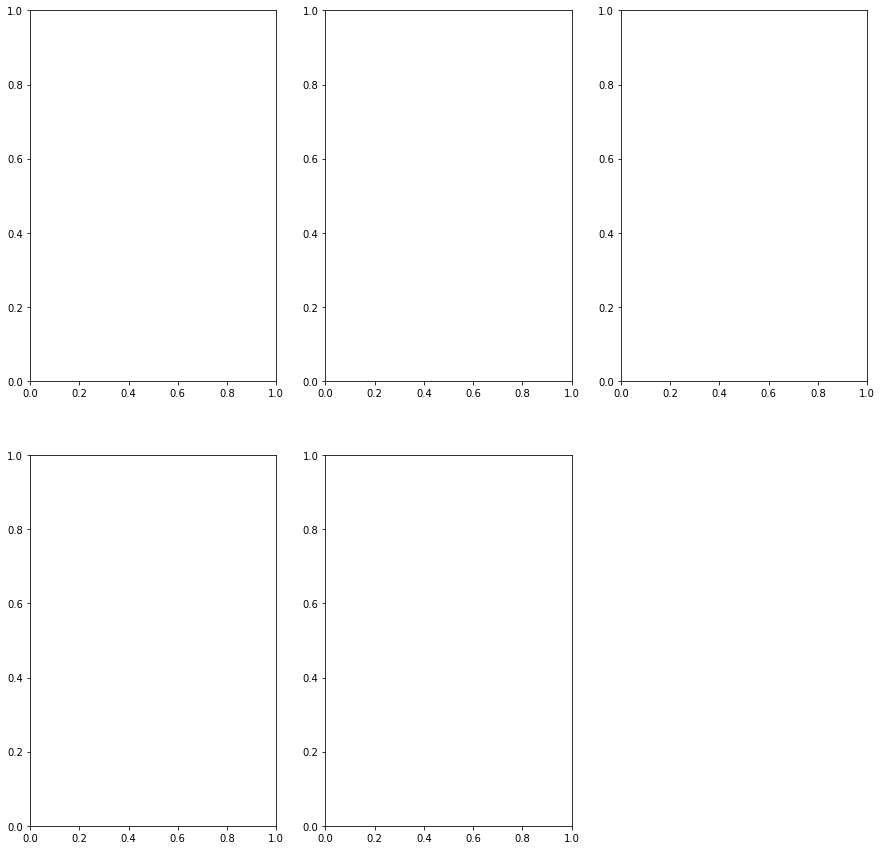

In [222]:
graph_centralities_creator(dataset,4,7)

# Part II

In this part we have to compute the common vertices between two time intervals (vertices_intersection) and the edges  in the first time interval(E_prev_set) and then to the following(E_next_set).

In [12]:
def vertices_intersection(dataset,t0,t1,t2):
    
    #Create two graphs
    G1 = graph(dataset,t0,t1) #for t-1,t
    G2 = graph(dataset,t1,t2) #for t, t+1
    
    S1=set(G1.graph.nodes())
    S2=set(G1.graph.nodes())
    
    return set.intersection(S1,S2) #Return the common nodes

In [13]:
def E_prev_set(dataset,t0,t1,t2):
    
    #Calculate the intersection
    G1 = graph(dataset,t0,t1) #for t-1,t
    G2 = graph(dataset,t1,t2) #for t, t+1
    
    S1 = set(G1.graph.nodes())
    S2 = set(G1.graph.nodes())
    
    intersection = set.intersection(S1,S2)

    #Calculate the the intersection vertices in [t-1, t)
    df = pd.DataFrame(columns = ["source_id", "target_id", "timestamp"])
    for row in G1.batch.itertuples():
        if (intersection is not set()) and(row.source_id and row.target_id in intersection) and (t0<=row.timestamp<t1):
            df = pd.concat([df,pd.DataFrame([row])],axis = 0)
    
    if not df.empty:
        del df['Index']
        df=df.reset_index(drop=True)

        #Calculate the intersection edges in [t-1, t)
        G= graph(df,t0,t1)

        return set(G.graph.edges())

In [14]:
def E_next_set(dataset,t0,t1,t2):
    
    #Calculate the intersection
    G1 = graph(dataset,t0,t1) #for t-1,t
    G2 = graph(dataset,t1,t2) #for t, t+1
    
    S1 = set(G1.graph.nodes())
    S2 = set(G1.graph.nodes())
    
    intersection = set.intersection(S1,S2)
    
    #Calculate the the intersection vertices in [t, t+1)
    df = pd.DataFrame(columns = ["source_id", "target_id", "timestamp"])
    for row in G2.batch.itertuples():
        if (row.source_id and row.target_id in intersection) and (t1<=row.timestamp<t2):
            df = pd.concat([df,pd.DataFrame([row])],axis = 0)
    
    if not df.empty:
        del df['Index']
        df=df.reset_index(drop=True)

        #Calculate the intersection edges in [t, t+1)
        G= graph(df,t1,t2)

        return set(G.graph.edges())

### Graphical Representation of the Volumes

In [15]:
def vertices_volume(dataset,N):
    
    time_intervals = create_intervals(dataset,N)
    intersection_list=[]
    i = 0
    for time_interval in time_intervals:
        if i < (len(time_intervals)-1):
            dt = time_interval[1] - time_interval[0]
            intersection_list.append(len(vertices_intersection(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)))
    
        
    return(intersection_list)

def create_vertices_graph(dataset,N):
    T=[]

    time_intervals = create_intervals(dataset,N)
    for time_interval in time_intervals:
        T.append(time_interval[0])

    x = T  
    y = vertices_volume(dataset,N)

    N = len(y)
    x = range(N)
    width = 1/1.5
    
    plt.subplot(1, 3, 1)
    plt.title('Vertices Histogram')
    plt.xlabel('Time Intervals Bins')
    plt.ylabel('Vertices Volume') 
    plt.bar(x, y, align='edge',color="blue")

In [16]:
def edges_prev_volume(dataset,N):
    
    time_intervals = create_intervals(dataset,N)
    prev_edge_list=[]
    i = 0
    for time_interval in time_intervals:
        if i < (len(time_intervals)-1):
            dt = time_interval[1] - time_interval[0]
            if E_prev_set(dataset, time_interval[0], time_interval[1], time_interval[1] + dt) is not None:
                prev_edge_list.append(len(E_prev_set(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)))
    
        
    return(prev_edge_list)

def create_prev_edge_graph(dataset,N):
    T=[]

    time_intervals = create_intervals(dataset,N)
    for time_interval in time_intervals:
        T.append(time_interval[0])

    x = T  
    y = edges_prev_volume(dataset,N)

    N = len(y)
    x = range(N)
    width = 1/1.5
    
    plt.subplot(1, 3, 2)
    plt.title('Edges_prev Histogram')
    plt.xlabel('Time Intervals Bins')
    plt.ylabel('Edges Volume') 
    plt.bar(x, y, align='edge',color="magenta")
    

In [17]:
def edges_next_volume(dataset,N):
    
    time_intervals = create_intervals(dataset,N)
    next_edge_list=[]
    i = 0
    for time_interval in time_intervals:
        if i < (len(time_intervals)-1):
            dt = time_interval[1] - time_interval[0]
            if E_next_set(dataset, time_interval[0], time_interval[1], time_interval[1] + dt) is not None:
                next_edge_list.append(len(E_next_set(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)))
    
        
    return(next_edge_list)

def create_next_edge_graph(dataset,N):
    T=[]

    time_intervals = create_intervals(dataset,N)
    for time_interval in time_intervals:
        T.append(time_interval[0])

    x = T  
    y = edges_next_volume(dataset,N)

    N = len(y)
    x = range(N)
    width = 1/1.5

    plt.subplot(1, 3, 3)
    plt.title('Edges_next Histogram')
    plt.xlabel('Time Intervals Bins')
    plt.ylabel('Edges Volume') 
    plt.bar(x, y, align='edge',color="red")

In [18]:
def graph_volumes_creator(dataset, n, N):
    data_rows = len(dataset)
    step = round(data_rows/n)
    start=0
    stop=step
    for pointer in range(0,data_rows,step):
        
        create_prev_edge_graph(dataset.iloc[start:stop],N)
        create_next_edge_graph(dataset.iloc[start:stop],N)
        create_vertices_graph(dataset.iloc[start:stop],N) 
        
        plt.tight_layout()
        plt.show()
        plt.clf()
        
        start = start + step
        stop = start + step

C:\Users\giorgos.papachristou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




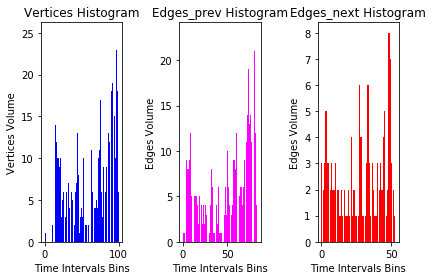

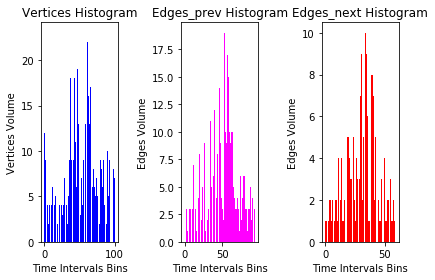

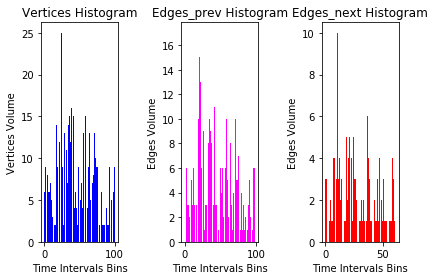

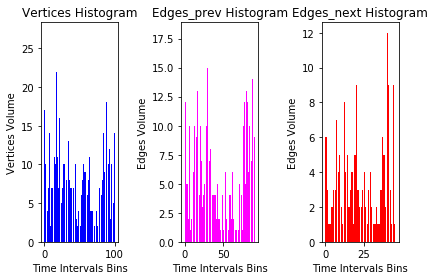

<Figure size 432x288 with 0 Axes>

In [97]:
graph_volumes_creator(dataset,4,100)

## Question 2

In [19]:
def graph_distance(dataset,t0,t1,t2):
    
    vertices_list = sorted(vertices_intersection(dataset,t0,t1,t2))
    edges_set = E_prev_set(dataset,t0,t1,t2)

    #Create the graph Object
    Gprev=nx.Graph()
    
    #Add the common vertices for the [t-1, t+1]
    Gprev.add_nodes_from(vertices_list)
    
    #Take the edges of the [t-1, t) interval
    if edges_set is not None:
        Gprev.add_edges_from(edges_set)
        
        #Graph distance calculation
        graph_matrix = pd.DataFrame(nx.floyd_warshall_numpy(Gprev), index=vertices_list, columns=vertices_list)
        pd.options.display.float_format = '{:,.0f}'.format
    
        return(graph_matrix)

Calculate the distance for all the time intervals

In [20]:
def calculate_graph_distance(dataset, N):
    
    time_intervals = create_intervals(dataset,N)
    
    for time_interval in time_intervals:

        dt = time_interval[1] - time_interval[0]
        
        #Graph Distance Calculation
        matrix = -graph_distance(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)
        
        if matrix is not None:
            print(matrix)
                 

In [21]:
def calculate_graph_distance_for_all_pairs(dataset, n, N):
    data_rows = len(dataset)
    step = round(data_rows/n)
    start=0
    stop=step
    for pointer in range(0,data_rows,step):
        
        calculate_graph_distance(dataset.iloc[start:stop], N)
        
        start = start + step
        stop = start + step

In [14]:
calculate_graph_distance_for_all_pairs(dataset,2, 10)

In [22]:
def common_neighbors(dataset, t0,t1,t2):
    
    vertices_list = sorted(vertices_intersection(dataset,t0,t1,t2))
    edges_set = E_prev_set(dataset,t0,t1,t2)
    
    #Create the graph Object
    Gprev=nx.Graph()
    
    #Add the common vertices for the [t-1, t+1]
    Gprev.add_nodes_from(vertices_list)
    
    #Take the edges of the [t-1, t) interval
    if edges_set is not None:
        Gprev.add_edges_from(edges_set)
    
    #Calculate all vertices permutations
    permutations = list(itertools.permutations(vertices_list, 2))

    df=pd.DataFrame(0,index=vertices_list, columns=vertices_list)

    for u,v in permutations:

        df.loc[u, v]= len(sorted(nx.common_neighbors(Gprev,u,v)))
    
    return(df)

Calculate the distance for all the time intervals

In [23]:
def calculate_common_neibhors_distance(dataset, N):
    
    time_intervals = create_intervals(dataset,N)
    
    for time_interval in time_intervals:

        dt = time_interval[1] - time_interval[0]

        #Common Neighbors Distance Calculation
        matrix=common_neighbors(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)
        if not matrix.empty:
            print(matrix)
        

In [24]:
def calculate_common_neibhors_distance_for_all_pairs(dataset, n, N):
    data_rows = len(dataset)
    step = round(data_rows/n)
    start=0
    stop=step
    for pointer in range(0,data_rows,step):
        
        calculate_common_neibhors_distance(dataset.iloc[start:stop], N)
        
        start = start + step
        stop = start + step

In [16]:
calculate_common_neibhors_distance_for_all_pairs(dataset,2, 10)

In [25]:
def jaccard_distance(dataset,t0,t1,t2):
    
    vertices_list = sorted(vertices_intersection(dataset,t0,t1,t2))
    edges_set = E_prev_set(dataset,t0,t1,t2)

    #Create the graph Object
    Gprev=nx.Graph()
    
    #Add the common vertices for the [t-1, t+1]
    Gprev.add_nodes_from(vertices_list)
    
    #Take the edges of the [t-1, t) interval
    if edges_set is not None:
        Gprev.add_edges_from(edges_set)
    
    jacc = list(nx.jaccard_coefficient(Gprev))

    df=pd.DataFrame(0,index=vertices_list, columns=vertices_list)

    for i in range(0,len(jacc)):
        df.loc[jacc[i][0],jacc[i][1]] = jacc[i][2]
        df.loc[jacc[i][1],jacc[i][0]] = jacc[i][2]
        
    return(df)   

Calculate the distance for all the time intervals

In [26]:
def calculate_jaccard_distance(dataset, N):
    
    time_intervals = create_intervals(dataset,N)
    
    for time_interval in time_intervals:

        dt = time_interval[1] - time_interval[0]

        #Common Neighbors Distance Calculation
        matrix=jaccard_distance(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)
        if (matrix is not None) and (not matrix.empty):
            print(matrix)

In [27]:
def calculate_jaccard_distance_for_all_pairs(dataset, n, N):
    data_rows = len(dataset)
    step = round(data_rows/n)
    start=0
    stop=step
    for pointer in range(0,data_rows,step):
        
        calculate_jaccard_distance(dataset.iloc[start:stop], N)
        
        start = start + step
        stop = start + step

In [17]:
calculate_jaccard_distance_for_all_pairs(dataset,2,10)

In [28]:
def adamic_adar_distance(dataset,t0,t1,t2):
    
    vertices_list = sorted(vertices_intersection(dataset,t0,t1,t2))
    edges_set = E_prev_set(dataset,t0,t1,t2)

    #Create the graph Object
    Gprev=nx.Graph()
    
    #Add the common vertices for the [t-1, t+1]
    Gprev.add_nodes_from(vertices_list)
    
    #Take the edges of the [t-1, t) interval
    if edges_set is not None:
        Gprev.add_edges_from(edges_set)
    
    adam = list(nx.adamic_adar_index(Gprev))

    df=pd.DataFrame(0,index=vertices_list, columns=vertices_list)

    for i in range(0,len(adam)):
        df.loc[adam[i][0],adam[i][1]] = adam[i][2]
        df.loc[adam[i][1],adam[i][0]] = adam[i][2]
        
    return(df)


Calculate the distance for all the time intervals

In [29]:
def calculate_adamic_adar_distance(dataset, N):
    
    time_intervals = create_intervals(dataset,N)
    
    for time_interval in time_intervals:

        dt = time_interval[1] - time_interval[0]

        #Common Neighbors Distance Calculation
        matrix=adamic_adar_distance(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)
        if (matrix is not None) and (not matrix.empty):
            print(matrix)

In [30]:
def calculate_adamic_adar_distance_for_all_pairs(dataset, n, N):
    data_rows = len(dataset)
    step = round(data_rows/n)
    start=0
    stop=step
    for pointer in range(0,data_rows,step):
        
        calculate_adamic_adar_distance(dataset.iloc[start:stop], N)
        
        start = start + step
        stop = start + step

In [18]:
calculate_adamic_adar_distance_for_all_pairs(dataset,2,10)

In [31]:
def preferencial_attachment(dataset,t0,t1,t2):
    
    vertices_list = sorted(vertices_intersection(dataset,t0,t1,t2))
    edges_set = E_prev_set(dataset,t0,t1,t2)

    #Create the graph Object
    Gprev=nx.Graph()
    
    #Add the common vertices for the [t-1, t+1]
    Gprev.add_nodes_from(vertices_list)
    
    #Take the edges of the [t-1, t) interval
    if edges_set is not None:
        Gprev.add_edges_from(edges_set)
    
    pref = list(nx.preferential_attachment(Gprev))

    df=pd.DataFrame(0,index=vertices_list, columns=vertices_list)

    for i in range(0,len(pref)):
            df.loc[pref[i][0],pref[i][1]] = pref[i][2]
            df.loc[pref[i][1],pref[i][0]] = pref[i][2]
            
    return(df)

Calculate the distance for all the time intervals

In [32]:
def calculate_preferencial_attachment_distance(dataset, N):
    
    time_intervals = create_intervals(dataset,N)
    
    for time_interval in time_intervals:

        dt = time_interval[1] - time_interval[0]

        #Common Neighbors Distance Calculation
        matrix=preferencial_attachment(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)
        if (matrix is not None) and (not matrix.empty):
            print(matrix)

In [33]:
def calculate_preferencial_attachment_distance_for_all_pairs(dataset, n, N):
    data_rows = len(dataset)
    step = round(data_rows/n)
    start=0
    stop=step
    for pointer in range(0,data_rows,step):
        
        calculate_preferencial_attachment_distance(dataset.iloc[start:stop], N)
        
        start = start + step
        stop = start + step

In [19]:
calculate_preferencial_attachment_distance_for_all_pairs(dataset,2,10)

# Part III

### ACC Function for Graph Distance Similarity Measure

In [56]:
def Graph_Distance_prev_ACC(dataset,N,Rxmin,Rxmax):
    
    ACC=[]
    
    #Calculation of TPR

    #Calculate the E*x[t-1,t+1]
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        TNR_flag = False
        TPR_flag = False

        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Calculation of λ
        E0 = len(vertices_intersection(dataset,t0,t1,t2))**2
        
        E_set=E_prev_set(dataset,t0,t1,t2)

        if E_set is not None:
            actual_edges = len(E_set)
        else:
            actual_edges = 0

        if E0 is not 0:
            lamda = actual_edges/E0


        #Common Neighbors Distance Calculation
        matrix=graph_distance(dataset, t0, t1, t2)
        filtered_edges = set()
        if (matrix is not None) and (not matrix.empty):
            for i in matrix.index:
                for j in matrix.index:
                    if i>j:
                        matrix_element = matrix[i][j]
                        if matrix_element>Rxmin and matrix_element<Rxmax:
                            filtered_edges.add((i,j))
                            
        
        #Calculation of TPR
        if E_set is not None:
            TPR_numerator = len(filtered_edges.intersection(E_set))
            TPR_denominator = len(E_prev_set(dataset,t0,t1,t2))
            TPR = TPR_numerator/TPR_denominator
            TPR_flag = True

        #Calculation of TNR
        if E_set is not None:
            TNR_numerator = len(filtered_edges)- len(filtered_edges.intersection(E_set))
            TNR_denominator = E0 - len(E_set)
            TNR = 1- TNR_numerator/TNR_denominator
            TNR_flag = True


        #Calculation of ACC
        if TNR_flag is True and TPR_flag is True:
            ACC.append(lamda*TPR +(1-lamda)*TNR)
        
    return(np.mean(ACC))

### ACC Function for Common Neighbors Similarity Measure

In [57]:
def Common_Neighbors_prev_ACC(dataset,N,Rxmin,Rxmax):

    ACC=[]
    
    #Calculation of TPR

    #Calculate the E*x[t-1,t+1]
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        TNR_flag = False
        TPR_flag = False

        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Calculation of λ
        E0 = len(vertices_intersection(dataset,t0,t1,t2))**2

        E_set=E_prev_set(dataset,t0,t1,t2)
        
        if E_set is not None:
            actual_edges = len(E_set)
        else:
            actual_edges = 0

        if E0 is not 0:
            lamda = actual_edges/E0


        #Common Neighbors Distance Calculation
        matrix=common_neighbors(dataset, t0, t1, t2)
        filtered_edges = set()
        if not matrix.empty:
            for i in matrix.index:
                for j in matrix.index:
                    if i>j:
                        matrix_element = matrix[i][j]
                        if matrix_element>Rxmin and matrix_element<Rxmax:
                            filtered_edges.add((i,j))
                            
        #Calculation of TPR
        if E_set is not None:
            TPR_numerator = len(filtered_edges.intersection(E_set))
            TPR_denominator = len(E_set)
            TPR = TPR_numerator/TPR_denominator
            TNR_flag = True

        #Calculation of TNR
        if E_set is not None:
            TNR_numerator = len(filtered_edges)- len(filtered_edges.intersection(E_set))
            TNR_denominator = E0 - len(E_set)
            TNR = 1- TNR_numerator/TNR_denominator
            TPR_flag = True


        #Calculation of ACC
        if TNR_flag is True and TPR_flag is True:
            ACC.append(lamda*TPR +(1-lamda)*TNR)
        
    return(np.mean(ACC))

### ACC Function for Jaccard Similarity Measure

In [58]:
def Jaccard_prev_ACC(dataset,N,Rxmin,Rxmax):

    ACC=[]
    
    #Calculation of TPR

    #Calculate the E*x[t-1,t+1]
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        TNR_flag = False
        TPR_flag = False
        
        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Calculation of λ
        E0 = len(vertices_intersection(dataset,t0,t1,t2))**2

        E_set=E_prev_set(dataset,t0,t1,t2)
        
        if E_prev_set(dataset,t0,t1,t2) is not None:
            actual_edges = len(E_set)
        else:
            actual_edges = 0

        if E0 is not 0:
            lamda = actual_edges/E0
        else:
            continue #THE LOOP WILL CONTINUE TO THE NEXT TIME INTERVAL


        #Jaccard Distance Calculation
        matrix=jaccard_distance(dataset, t0, t1, t2)
        filtered_edges = set()
        if not matrix.empty:
            for i in matrix.index:
                for j in matrix.index:
                    if i>j:
                        matrix_element = matrix[i][j]
                        if matrix_element>Rxmin and matrix_element<Rxmax:
                            filtered_edges.add((i,j))
            #Calculation of TPR
            if E_set is not None:
                TPR_numerator = len(filtered_edges.intersection(E_set))
                TPR_denominator = len(E_set)
                if TPR_denominator is not 0:
                    TPR = TPR_numerator/TPR_denominator
                    TPR_flag = True


            #Calculation of TNR
            if E_set is not None:
                TNR_numerator = len(filtered_edges)- len(filtered_edges.intersection(E_set))
                TNR_denominator = E0 - len(E_set)
                if TNR_denominator is not 0:
                    TNR = 1- TNR_numerator/TNR_denominator
                    TNR_flag = True


        if TNR_flag is True and TPR_flag is True:
            #Calculation of ACC
            ACC.append(lamda*TPR +(1-lamda)*TNR)
        
    return(np.mean(ACC))

### ACC Function for Adamic Adar Similarity Measure

In [59]:
def Adamic_Adar_prev_ACC(dataset,N,Rxmin,Rxmax):
    
    ACC=[]
    
    #Calculation of TPR

    #Calculate the E*x[t-1,t+1]
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        TNR_flag = False
        TPR_flag = False

        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Calculation of λ
        E0 = len(vertices_intersection(dataset,t0,t1,t2))**2

        E_set = E_prev_set(dataset,t0,t1,t2)
        
        if E_set is not None:
            actual_edges = len(E_set)
        else:
            actual_edges = 0

        if E0 is not 0:
            lamda = actual_edges/E0


        #Adamic Adar Distance Calculation
        matrix=adamic_adar_distance(dataset, t0, t1, t2)
        filtered_edges = set()
        if not matrix.empty:
            for i in matrix.index:
                for j in matrix.index:
                    if i>j:
                        matrix_element = matrix[i][j]
                        if matrix_element>Rxmin and matrix_element<Rxmax:
                            filtered_edges.add((i,j))
                            
        #Calculation of TPR
        if E_prev_set(dataset,t0,t1,t2)is not None:
            TPR_numerator = len(filtered_edges.intersection(E_set))
            TPR_denominator = len(E_set)
            if TPR_denominator is not 0:
                TPR = TPR_numerator/TPR_denominator
                TPR_flag = True


        #Calculation of TNR
        if E_set is not None:
            TNR_numerator = len(filtered_edges)- len(filtered_edges.intersection(E_set))
            TNR_denominator = E0 - len(E_set)
            if TNR_denominator is not 0:
                TNR = 1- TNR_numerator/TNR_denominator
                TNR_flag = True
 

        #Calculation of ACC
        if TNR_flag is True and TPR_flag is True:
            ACC.append(lamda*TPR +(1-lamda)*TNR)
        
    return(np.mean(ACC))

### ACC Function for Preferential Attachment Similarity Measure

In [60]:
def Preferencial_Attachment_prev_ACC(dataset,N,Rxmin,Rxmax):

    ACC=[]
    
    #Calculation of TPR

    #Calculate the E*x[t-1,t+1]
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        TNR_flag = False
        TPR_flag = False

        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Calculation of λ
        E0 = len(vertices_intersection(dataset,t0,t1,t2))**2
        
        E_set = E_prev_set(dataset,t0,t1,t2)

        if E_set is not None:
            actual_edges = len(E_set)
        else:
            actual_edges = 0

        if E0 is not 0:
            lamda = actual_edges/E0


        #Preferencialattachment Calculation
        matrix=preferencial_attachment(dataset, t0, t1, t2)
        filtered_edges = set()
        if not matrix.empty:
            for i in matrix.index:
                for j in matrix.index:
                    if i>j:
                        matrix_element = matrix[i][j]
                        if matrix_element>Rxmin and matrix_element<Rxmax:
                            filtered_edges.add((i,j))
        #Calculation of TPR
        if E_set is not None:
            TPR_numerator = len(filtered_edges.intersection(E_set))
            TPR_denominator = len(E_set)
            TPR = TPR_numerator/TPR_denominator
            TPR_flag = True


        #Calculation of TNR
        if E_set is not None:
            TNR_numerator = len(filtered_edges)- len(filtered_edges.intersection(E_set))
            TNR_denominator = E0 - len(E_set)
            TNR = 1- TNR_numerator/TNR_denominator
            TNR_flag = True

        #Calculation of ACC
        if TNR_flag is True and TPR_flag is True:
            ACC.append(lamda*TPR +(1-lamda)*TNR)
        
    return(np.mean(ACC))

In [61]:
def calculate_similarity_values(method,dataset,N):
    
    flag=True
    
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Jaccard Distance Calculation
        matrix=method(dataset, t0, t1, t2)
        
        if matrix is not None:
            return np.unique(matrix.values)

The following code calculates the range of similarity values for each distance metric. The following code is for illustrating purposes.

In [40]:
S=[graph_distance,common_neighbors,jaccard_distance,adamic_adar_distance,preferencial_attachment]

for distance_method in S:
    print(distance_method.__name__,calculate_similarity_values(distance_method,dataset,10))

graph_distance [ 0.  1. inf]
common_neighbors [0]
jaccard_distance [0.]
adamic_adar_distance [0]
preferencial_attachment [0 2]


C:\Users\giorgos.papachristou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


The following function calculates the optimal range of values for the similarity score. The logic behind this function is firstly to calculate the values of the similarity matrix and then start to reduce the range and keep the best accuracy score.

In [40]:
def calculate_R_range(method,ACC_method,dataset,N, iterations):

    S=calculate_similarity_values(method,dataset,N)
    
    Rmin=0
    Rmax=len(S)-1
    
    Rmin_value = Rmin
    Rmax_value = Rmax
    iterations_num = 0
    
    best_ACC=ACC_method(dataset,N,Rmin,Rmax)
    while Rmin+1 < Rmax and iterations_num < iterations:

        ACC_next=ACC_method(dataset,10,S[Rmin+1],S[Rmax])
        if ACC_next>best_ACC:
            best_ACC = ACC_next
            Rmin_value=Rmin+1

        ACC_prev=ACC_method(dataset,10,S[Rmin],S[Rmax-1])    
        if ACC_prev>best_ACC:
            best_ACC = ACC_prev
            Rmax_value=Rmax-1

        Rmin = Rmin+1    
        Rmax = Rmax-1
        iterations_num += 1
        
    return(method.__name__,best_ACC,[S[Rmin_value],S[Rmax_value]])  

The following function breaks the dataset to N smaller datasets. If we don't use this approach the algorythm isn't efficient because have to load all the data and use only a part of them, because every time we need only two time intervals NOT ALL, AT THE SAME TIME.

In [41]:
def calculate_R_range_batches(method,ACC_method,dataset,N, iterations,n):  
    
    #Break the dataset to N-datasets
    data_rows = len(dataset)
    step = round(data_rows/n)
    start=0
    stop=step
    method_list=method
    method_list=list()
    
    for pointer in range(0,data_rows,step):
        
        data_batch=dataset.iloc[start:stop]
        calculate_R=calculate_R_range(method,ACC_method,data_batch,N, iterations)
        
        method_list.append(calculate_R[1])
        
        start = start + step
        stop = stop + step
    return(method_list)   

Now we can calculate the Accuracy for the testing dataset

In [108]:
S=[[graph_distance,Graph_Distance_prev_ACC],
   [common_neighbors,Common_Neighbors_prev_ACC],
   [jaccard_distance,Jaccard_ACC],
   [adamic_adar_distance,Adamic_Adar_prev_ACC],
   [preferencial_attachment,Preferencial_Attachment_prev_ACC]]

for distance_method,ACC_method in S:
    print(calculate_R_range(distance_method,ACC_method,dataset,10, 10))

('graph_distance', 0.9649977978455606, [0.0, inf])
('common_neighbors', 0.9534639741474817, [0, 0])
('jaccard_distance', 0.9534639741474817, [0.0, 0.0])
('adamic_adar_distance', 0.9534639741474817, [0, 0])
('preferencial_attachment', 0.9534639741474817, [0, 2])


In [94]:
S=[[graph_distance,Graph_Distance_prev_ACC],
   [common_neighbors,Common_Neighbors_prev_ACC],
   [jaccard_distance,Jaccard_prev_ACC],
   [adamic_adar_distance,Adamic_Adar_prev_ACC],
   [preferencial_attachment,Preferencial_Attachment_prev_ACC]]

results=list()

for distance_method,ACC_method in S:
    result=calculate_R_range_batches(distance_method,ACC_method,dataset,10, 10,4)
    results.append(result)
    print(distance_method.__name__)
    print("ACC values: ",result)
    print("Average value: ",np.mean(result))

C:\Users\geop\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


graph_distance
ACC values:  [0.9609519669082041, 0.9600135240424252, 0.9082645225841368, 0.9543301678751777]
Average value:  0.9458900453524859
common_neighbors
ACC values:  [0.9441582859365655, 0.9600135240424252, 0.9342636592731474, 0.9675437136592253]
Average value:  0.9514947957278408
jaccard_distance
ACC values:  [0.9441582859365655, 0.9600135240424252, 0.9340570477028993, 0.9674289830118736]
Average value:  0.9514144601734409
adamic_adar_distance
ACC values:  [0.9441582859365655, 0.9592590878632787, 0.9272253063414884, 0.968382205240746]
Average value:  0.9497562213455197
preferencial_attachment
ACC values:  [0.9441582859365655, 0.9600135240424252, 0.8373476066107765, 0.9637811864852134]
Average value:  0.9263251507687452


We plot the final results of the accuracy for the training data.

[Text(0,0,'Graph Distance'),
 Text(0,0,'Common Neighbors'),
 Text(0,0,'Jaccard Distance'),
 Text(0,0,'Adamic Adar Distance'),
 Text(0,0,'Preferencial Attachment')]

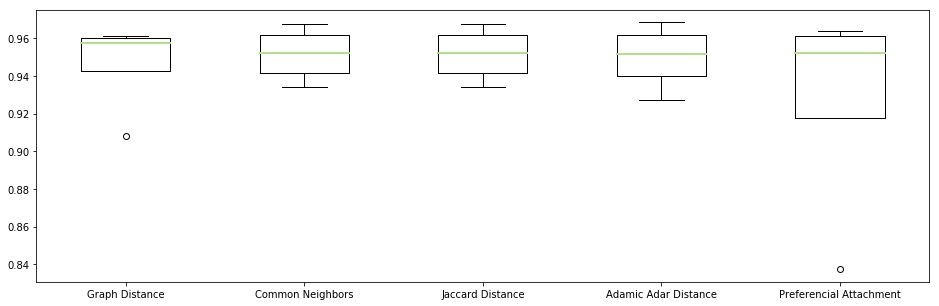

In [95]:
# Create a figure instance
fig = plt.figure(1, figsize=(16, 5))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(results)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)
    
## Custom x-axis labels
ax.set_xticklabels(["Graph Distance",
                      "Common Neighbors",
                      "Jaccard Distance",
                      "Adamic Adar Distance",
                      "Preferencial Attachment"])

In the following cells we calculate the accuracy for the test dataset

### ACC Function for Graph Distance Similarity Measure

In [49]:
def Graph_Distance_next_ACC(dataset,N,Rxmin,Rxmax):
    
    ACC=[]
    
    #Calculation of TPR

    #Calculate the E*x[t-1,t+1]
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        TNR_flag = False
        TPR_flag = False

        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Calculation of λ
        E0 = len(vertices_intersection(dataset,t0,t1,t2))**2

        E_set = E_next_set(dataset,t0,t1,t2)
        if E_set is not None:
            actual_edges = len(E_set)
        else:
            actual_edges = 0

        if E0 is not 0:
            lamda = actual_edges/E0


        #Common Neighbors Distance Calculation
        matrix=graph_distance(dataset, t0, t1, t2)
        filtered_edges = set()
        if (matrix is not None) and (not matrix.empty):
            for i in matrix.index:
                for j in matrix.index:
                    if i>j:
                        matrix_element = matrix[i][j]
                        if matrix_element>Rxmin and matrix_element<Rxmax:
                            filtered_edges.add((i,j))
                            
        
        #Calculation of TPR
        if E_set is not None:
            TPR_numerator = len(filtered_edges.intersection(E_set))
            TPR_denominator = len(E_next_set(dataset,t0,t1,t2))
            TPR = TPR_numerator/TPR_denominator
            TPR_flag = True

        #Calculation of TNR
        if E_set is not None:
            TNR_numerator = len(filtered_edges)- len(filtered_edges.intersection(E_set))
            TNR_denominator = E0 - len(E_set)
            TNR = 1- TNR_numerator/TNR_denominator
            TNR_flag = True


        #Calculation of ACC
        if TNR_flag is True and TPR_flag is True:
            ACC.append(lamda*TPR +(1-lamda)*TNR)
        
    return(np.mean(ACC))

### ACC Function for Common Neighbors Similarity Measure

In [50]:
def Common_Neighbors_next_ACC(dataset,N,Rxmin,Rxmax):

    ACC=[]
    
    #Calculation of TPR

    #Calculate the E*x[t-1,t+1]
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        TNR_flag = False
        TPR_flag = False

        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Calculation of λ
        E0 = len(vertices_intersection(dataset,t0,t1,t2))**2

        E_set = E_next_set(dataset,t0,t1,t2)
        
        if E_set is not None:
            actual_edges = len(E_set)
        else:
            actual_edges = 0

        if E0 is not 0:
            lamda = actual_edges/E0


        #Common Neighbors Distance Calculation
        matrix=common_neighbors(dataset, t0, t1, t2)
        filtered_edges = set()
        if not matrix.empty:
            for i in matrix.index:
                for j in matrix.index:
                    if i>j:
                        matrix_element = matrix[i][j]
                        if matrix_element>Rxmin and matrix_element<Rxmax:
                            filtered_edges.add((i,j))
                            
        #Calculation of TPR
        if E_set is not None:
            TPR_numerator = len(filtered_edges.intersection(E_set))
            TPR_denominator = len(E_set)
            TPR = TPR_numerator/TPR_denominator
            TNR_flag = True

        #Calculation of TNR
        if E_set is not None:
            TNR_numerator = len(filtered_edges)- len(filtered_edges.intersection(E_set))
            TNR_denominator = E0 - len(E_set)
            TNR = 1- TNR_numerator/TNR_denominator
            TPR_flag = True


        #Calculation of ACC
        if TNR_flag is True and TPR_flag is True:
            ACC.append(lamda*TPR +(1-lamda)*TNR)
        
    return(np.mean(ACC))

### ACC Function for Jaccard Similarity Measure

In [51]:
def Jaccard_next_ACC(dataset,N,Rxmin,Rxmax):

    ACC=[]
    
    #Calculation of TPR

    #Calculate the E*x[t-1,t+1]
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        TNR_flag = False
        TPR_flag = False
        
        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Calculation of λ
        E0 = len(vertices_intersection(dataset,t0,t1,t2))**2

        E_set = E_next_set(dataset,t0,t1,t2)
        
        if E_set is not None:
            actual_edges = len(E_set)
        else:
            actual_edges = 0

        if E0 is not 0:
            lamda = actual_edges/E0
        else:
            continue #THE LOOP WILL CONTINUE TO THE NEXT TIME INTERVAL


        #Jaccard Distance Calculation
        matrix=jaccard_distance(dataset, t0, t1, t2)
        filtered_edges = set()
        if not matrix.empty:
            for i in matrix.index:
                for j in matrix.index:
                    if i>j:
                        matrix_element = matrix[i][j]
                        if matrix_element>Rxmin and matrix_element<Rxmax:
                            filtered_edges.add((i,j))
            #Calculation of TPR
            if E_set is not None:
                TPR_numerator = len(filtered_edges.intersection(E_set))
                TPR_denominator = len(E_set)
                if TPR_denominator is not 0:
                    TPR = TPR_numerator/TPR_denominator
                    TPR_flag = True


            #Calculation of TNR
            if E_set is not None:
                TNR_numerator = len(filtered_edges)- len(filtered_edges.intersection(E_set))
                TNR_denominator = E0 - len(E_set)
                if TNR_denominator is not 0:
                    TNR = 1- TNR_numerator/TNR_denominator
                    TNR_flag = True


        if TNR_flag is True and TPR_flag is True:
            #Calculation of ACC
            ACC.append(lamda*TPR +(1-lamda)*TNR)
        
    return(np.mean(ACC))

Estimate the range of the R parameter 

### ACC Function for Adamic Adar Similarity Measure

In [52]:
def Adamic_Adar_next_ACC(dataset,N,Rxmin,Rxmax):
    
    ACC=[]
    
    #Calculation of TPR

    #Calculate the E*x[t-1,t+1]
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        TNR_flag = False
        TPR_flag = False

        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Calculation of λ
        E0 = len(vertices_intersection(dataset,t0,t1,t2))**2

        E_set = E_next_set(dataset,t0,t1,t2)
        
        if E_next_set(dataset,t0,t1,t2) is not None:
            actual_edges = len(E_set)
        else:
            actual_edges = 0

        if E0 is not 0:
            lamda = actual_edges/E0


        #Adamic Adar Distance Calculation
        matrix=adamic_adar_distance(dataset, t0, t1, t2)
        filtered_edges = set()
        if not matrix.empty:
            for i in matrix.index:
                for j in matrix.index:
                    if i>j:
                        matrix_element = matrix[i][j]
                        if matrix_element>Rxmin and matrix_element<Rxmax:
                            filtered_edges.add((i,j))
                            
        #Calculation of TPR
        if E_set is not None:
            TPR_numerator = len(filtered_edges.intersection(E_set))
            TPR_denominator = len(E_set)
            if TPR_denominator is not 0:
                TPR = TPR_numerator/TPR_denominator
                TPR_flag = True


        #Calculation of TNR
        if E_set is not None:
            TNR_numerator = len(filtered_edges)- len(filtered_edges.intersection(E_set))
            TNR_denominator = E0 - len(E_set)
            if TNR_denominator is not 0:
                TNR = 1- TNR_numerator/TNR_denominator
                TNR_flag = True
 

        #Calculation of ACC
        if TNR_flag is True and TPR_flag is True:
            ACC.append(lamda*TPR +(1-lamda)*TNR)
        
    return(np.mean(ACC))

### ACC Function for Preferential Attachment Similarity Measure

In [53]:
def Preferencial_Attachment_next_ACC(dataset,N,Rxmin,Rxmax):

    ACC=[]
    
    #Calculation of TPR

    #Calculate the E*x[t-1,t+1]
    time_intervals = create_intervals(dataset,N)  
    for time_interval in time_intervals:
        
        TNR_flag = False
        TPR_flag = False

        dt = time_interval[1] - time_interval[0]

        t0 = time_interval[0]
        t1 = time_interval[1]
        t2 = time_interval[1] + dt

        #Calculation of λ
        E0 = len(vertices_intersection(dataset,t0,t1,t2))**2

        E_set = E_next_set(dataset,t0,t1,t2)
        if E_next_set(dataset,t0,t1,t2) is not None:
            actual_edges = len(E_set)
        else:
            actual_edges = 0

        if E0 is not 0:
            lamda = actual_edges/E0


        #Preferencialattachment Calculation
        matrix=preferencial_attachment(dataset, t0, t1, t2)
        filtered_edges = set()
        if not matrix.empty:
            for i in matrix.index:
                for j in matrix.index:
                    if i>j:
                        matrix_element = matrix[i][j]
                        if matrix_element>Rxmin and matrix_element<Rxmax:
                            filtered_edges.add((i,j))
        #Calculation of TPR
        if E_set is not None:
            TPR_numerator = len(filtered_edges.intersection(E_set))
            TPR_denominator = len(E_set)
            TPR = TPR_numerator/TPR_denominator
            TPR_flag = True


        #Calculation of TNR
        if E_set is not None:
            TNR_numerator = len(filtered_edges)- len(filtered_edges.intersection(E_set))
            TNR_denominator = E0 - len(E_set)
            TNR = 1- TNR_numerator/TNR_denominator
            TNR_flag = True

        #Calculation of ACC
        if TNR_flag is True and TPR_flag is True:
            ACC.append(lamda*TPR +(1-lamda)*TNR)
        
    return(np.mean(ACC))

In [54]:
def calculate_R_range(method,ACC_method,dataset,N, iterations):

    S=calculate_similarity_values(method,dataset,N)
    
    Rmin=0
    Rmax=len(S)-1
    
    Rmin_value=Rmin
    Rmax_value=Rmax
    iterations_num = 0
    
    best_ACC=ACC_method(dataset,N,Rmin,Rmax)
    while Rmin+1 < Rmax and iterations_num < iterations:

        ACC_next=ACC_method(dataset,10,S[Rmin+1],S[Rmax])
        if ACC_next>best_ACC:
            best_ACC = ACC_next
            Rmin_value=Rmin+1

        ACC_prev=ACC_method(dataset,10,S[Rmin],S[Rmax-1])    
        if ACC_prev>best_ACC:
            best_ACC = ACC_prev
            Rmax_value=Rmax-1

        Rmin = Rmin+1    
        Rmax = Rmax-1
        iterations_num += 1
        
    return(method.__name__,best_ACC,[S[Rmin_value],S[Rmax_value]])    

In [116]:
S=[[graph_distance,Graph_Distance_next_ACC],
   [common_neighbors,Common_Neighbors_next_ACC],
   [jaccard_distance,Jaccard_next_ACC],
   [adamic_adar_distance,Adamic_Adar_next_ACC],
   [preferencial_attachment,Preferencial_Attachment_next_ACC]]

for distance_method,ACC_method in S:
    print(calculate_R_range(distance_method,ACC_method,dataset,10,10))
   

('graph_distance', 0.9234790218137151, [0.0, 1.0])
('common_neighbors', 0.9234790218137151, [0, 0])
('jaccard_distance', 0.9234790218137151, [0.0, 0.0])
('adamic_adar_distance', 0.9234790218137151, [0, 0])
('preferencial_attachment', 0.9234790218137151, [0, 2])


In [144]:
S=[[graph_distance,Graph_Distance_next_ACC],
   [common_neighbors,Common_Neighbors_next_ACC],
   [jaccard_distance,Jaccard_next_ACC],
   [adamic_adar_distance,Adamic_Adar_next_ACC],
   [preferencial_attachment,Preferencial_Attachment_next_ACC]]

results=list()

for distance_method,ACC_method in S:
    result=calculate_R_range_batches(distance_method,ACC_method,dataset,10, 10,4)
    results.append(result)
    print(distance_method.__name__)
    print("ACC values: ",result)
    print("Average value: ",np.mean(result))

C:\Users\giorgos.papachristou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




graph_distance
ACC values:  [0.9234790218137151, 0.9441261878100227, 0.9917638796518787, 0.9428918272826419]
Average value:  0.9505652291395645
common_neighbors
ACC values:  [0.9234790218137151, 0.9904558565951526, 0.9917638796518787, 0.9889456565934349]
Average value:  0.9736611036635453
jaccard_distance
ACC values:  [0.9234790218137151, 0.9903108358414224, 0.9883448948656899, 0.9888732285795097]
Average value:  0.9727519952750843
adamic_adar_distance
ACC values:  [0.9234790218137151, 0.9795500524596008, 0.9865124119252042, 0.9866290742073266]
Average value:  0.9690426401014617
preferencial_attachment
ACC values:  [0.9234790218137151, 0.9800824435103083, 0.9917638796518787, 0.9836608032590414]
Average value:  0.9697465370587359


We plot the final results of the accuracy for the test data.

[Text(0,0,'Graph Distance'),
 Text(0,0,'Common Neighbors'),
 Text(0,0,'Jaccard Distance'),
 Text(0,0,'Adamic Adar Distance'),
 Text(0,0,'Preferencial Attachment')]

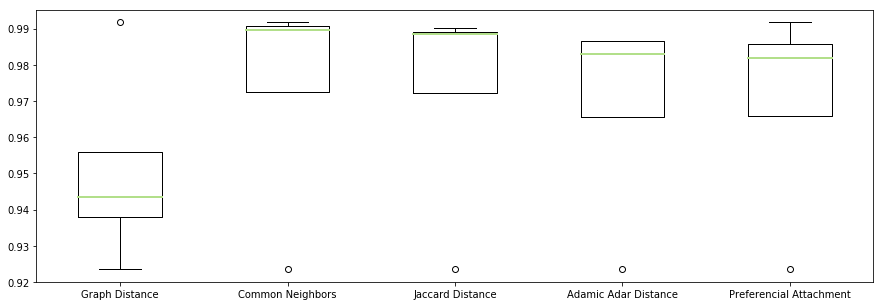

In [145]:
# Create a figure instance
fig = plt.figure(1, figsize=(15, 5))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(results)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)
    
## Custom x-axis labels
ax.set_xticklabels(["Graph Distance",
                      "Common Neighbors",
                      "Jaccard Distance",
                      "Adamic Adar Distance",
                      "Preferencial Attachment"])

## Extra Investigation

In all the above questions we had a fix number(N=10) for time intervals. Now we will investigate how the number of time intervals affect the accuracy of our results. For our testing we test only for one metric "graph distance", because is the method with the lowest time complexity.

In [88]:
results_prev=list()
results_next=list()
max_number_N=50
dataset=data.iloc[0:5000]

for N in range(1,max_number_N):
    result_prev=calculate_R_range(graph_distance,Graph_Distance_prev_ACC,dataset,N, 10)
    print(result_prev)
    result_next=calculate_R_range(graph_distance,Graph_Distance_next_ACC,dataset,N, 10)
    print(result_next)
    results_prev.append(result_prev[1])
    results_next.append(result_next[1])

C:\Users\geop\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


('graph_distance', 0.9905055269049626, [4.0, 7.0])
('graph_distance', 0.992922987647933, [4.0, 7.0])
('graph_distance', 0.9905055269049626, [4.0, 7.0])
('graph_distance', 0.992922987647933, [4.0, 7.0])
('graph_distance', 0.8788299624758869, [3.0, 4.0])
('graph_distance', 0.8822642691667829, [3.0, 4.0])
('graph_distance', 0.9905055269049626, [4.0, 7.0])
('graph_distance', 0.992922987647933, [4.0, 7.0])
('graph_distance', 0.9905055269049626, [4.0, 7.0])
('graph_distance', 0.992922987647933, [4.0, 7.0])
('graph_distance', 0.9905055269049626, [4.0, 7.0])
('graph_distance', 0.992922987647933, [4.0, 7.0])
('graph_distance', 0.9024408289837597, [4.0, 8.0])
('graph_distance', 0.9051729174567816, [4.0, inf])
('graph_distance', 0.9024408289837597, [4.0, 8.0])
('graph_distance', 0.9051729174567816, [4.0, inf])
('graph_distance', 0.9024408289837597, [4.0, 8.0])
('graph_distance', 0.9051729174567816, [4.0, inf])
('graph_distance', 0.9905055269049626, [5.0, inf])
('graph_distance', 0.992922987647933

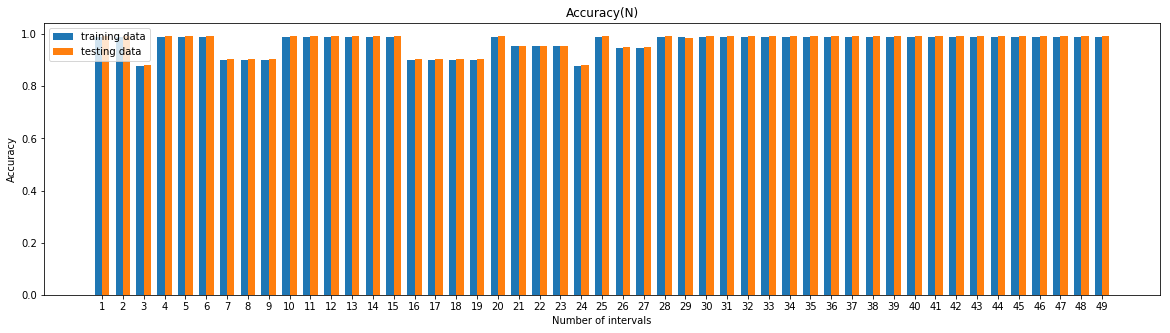

In [91]:
# Create a figure instance
fig = plt.figure(1, figsize=(20, 5))

ind = np.arange(max_number_N-1) 
width = 0.35      

plt.bar(ind, results_prev, width, label='training data')
plt.bar(ind + width, results_next, width,
    label='testing data')

plt.xlabel("Number of intervals")
plt.ylabel("Accuracy")
plt.title("Accuracy(N)")

plt.xticks(ind + width / 2,range(1,max_number_N))
plt.legend(loc='best')
plt.show()

As we can see as we change the number of intervals and accordingly the number of nodes and edges which we take into consideration the accuracy is not affected significantly.